In [52]:
# Change here using YOUR own first and last names
fn1 = "Jiale"
ln1 = "KANG"
filename = "_".join(map(lambda s: s.strip().lower(),
                        ["SD-TSIA204_lab2", ln1, fn1])) + ".ipynb"

print(filename)

sd-tsia204_lab2_kang_jiale.ipynb


In [53]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error as sklearn_mse
from sklearn.metrics import r2_score as sklearn_r2
import numpy as np

from scipy import stats

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from scipy.stats import norm
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# use dataset fetch_california_housing

1\) For the first question, we load a standard dataset from sklearn.datasets named fetch_california_housing. This dataset has only $p = 8$ variables.

(a) Estimate the coefficients with the expression of the normal equaitons seen in class. Code two functions to compute the MSE and the R2 coefficient and compare them with the version of sklearn for the train and the test sets.

In [54]:
# load the dataset
data_set = fetch_california_housing()
X = data_set.data
y = data_set.target

# adding a column of ones to X and we do not splite the dataset
X = np.c_[np.ones(X.shape[0]), X]

# theta = (X^T X)^(-1) X^T y
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

def compute_MSE(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def compute_R2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

y_pred = X.dot(theta)

# compare the MSE and R2 with version of sklearn
my_mse = compute_MSE(y, y_pred)
my_r2 = compute_R2(y, y_pred)
sklearn_mse = sklearn_mse(y, y_pred)
sklearn_r2 = sklearn_r2(y, y_pred)
print("my MSE:", my_mse, "Sklearn MSE:", sklearn_mse)
print("my R2 :", my_r2, "Sklearn R2 :", sklearn_r2)

my MSE: 0.524320986184607 Sklearn MSE: 0.524320986184607
my R2 : 0.6062326851998052 Sklearn R2 : 0.6062326851998052


(b) Finally, give the confidence intervals at level 99% for all the coefficients coding the expression for the CI seen in session 3.

In [55]:
# Compute the residuals and their variance
residuals = y - y_pred
sigma_squared = np.mean(residuals ** 2)

# Compute the standard errors
XtX_inv = np.linalg.inv(X.T.dot(X))
standard_errors = np.sqrt(np.diag(sigma_squared * XtX_inv))

z = stats.norm.ppf(0.995)
confidence_intervals = [(theta[i] - z * standard_errors[i],
                         theta[i] + z * standard_errors[i]) for i in range(len(theta))]

for i, ci in enumerate(confidence_intervals):
    print(f"Coefficient {i}: 99% CI = {ci}")

Coefficient 0: 99% CI = (-38.63874945118044, -35.24509096143688)
Coefficient 1: 99% CI = (0.42588540249626045, 0.4475011837773342)
Coefficient 2: 99% CI = (0.008286488997305977, 0.010585067069474924)
Coefficient 3: 99% CI = (-0.12247846827219933, -0.09216561451536173)
Coefficient 4: 99% CI = (0.5726106847258521, 0.7175207023358563)
Coefficient 5: 99% CI = (-1.6206846472410517e-05, 8.25406763075563e-06)
Coefficient 6: 99% CI = (-0.0050417663608660936, -0.0025313189491208005)
Coefficient 7: 99% CI = (-0.43984823431362086, -0.4027805207223839)
Coefficient 8: 99% CI = (-0.4539129628944105, -0.4151145464347442)


# use the dataset data_dm3 in eCampus

2\) For the rest of the TP, we use the dataset in eCampus data. Load and preprocess the data:

(a) Separate the data in train and test sets: save one fourth of the data as testing (train_test_split from sklearn.model_selection with the random seed set to 0 and
standardize both the training and testing sets using the fit_transform and transform functions in sklearn.preprocessing.StandardScaler.

In [56]:
# load the dataset
data = pd.read_csv("data.csv", sep=",", header=None)

# Set the random seed to 0
np.random.seed(0)

# Split the data into a training and a test set (75% - 25%)
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(210, axis=1), data[210], test_size=0.25, random_state=0)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1)).ravel()

(b) Fit a regular OLS.

In [57]:
# Fit a regular OLS
reg = LinearRegression(fit_intercept=False).fit(X_train_scaled, y_train_scaled)
print(f'R^2 = {reg.score(X_test_scaled, y_test_scaled)}')

R^2 = 0.15748913863221714


# Variable selection

3\) Program the method of forward variable selection based on hypothesis tests for regression coefficients.
This method starts from an empty set of variables $S$ and at each iteration selects one variable relevant for predicting $y$ and includes it in the set $S$. It runs until a halting condition is met. The coding process is as follows:

(a) Develop a function that, given a dataset $X \in \mathbb{R}^{n\times p}$ and $y$, fits $p$ linear regression models, each using only feature $X_j4 to predict $y$. For each model, conduct a test of no effect, as discussed in session 3, and compute the p-value of the test. This function should return the coefficient with the smallest p-value. Explain the significance of the p-value in this context.

In [58]:
# @brief: Choose the best single variable to predict y from X.
# @param X: The data matrix of shape (n, p).
# @param y: The vector of responses of shape (n,).
# @param plot_flag: If True, plot the p-values of all features.
# @param plot_label: The label of the plot.
# @return: (index of the best single variable, p-value of the best single variable, centered X, theta)

def choose_single_variable(X, y, plot_flag, plot_label):

    n, p = X.shape
    p_values = []
    y_temp = y.copy().ravel()

    # Iterate through all unselected features to find the one with smallest p-value
    for k in range(p):
        # Select column with index k
        X_temp = X[:, k]  

        # centerilize X and y
        Xc = X_temp - np.mean(X_temp)
        yc = y_temp - np.mean(y_temp)

        # fit a regular OLS
        reg = LinearRegression().fit(Xc.reshape(-1, 1), yc)
        theta = reg.coef_
        y_pred = reg.predict(Xc.reshape(-1, 1))

        # conduct a t-test of no effect
        sigma = np.sqrt(np.var(yc - y_pred))
        T = np.sqrt(n) * abs(theta) / sigma
        p_value = 2 * (1 - stats.t.cdf(np.abs(T), n - 2))
        p_values.append([k, p_value, Xc, theta])

    if plot_flag:
        k_values = [entry[0] for entry in p_values]
        p_values_list = [entry[1] for entry in p_values]
        plt.scatter(k_values, p_values_list, label=plot_label)
        plt.legend()

    return min(p_values, key=lambda x: x[1])

(b) Apply the function iteratively. At each iteration, select the feature $X_f$ with the smallest p-value and:

- i. Include it in the set $S$.
- ii. Remove it from $X$.
- iii. Subtract from $y$ the residuals of the model fit with feature $X_f$ . Elaborate on the reason for subtracting the residuals.

(c) Add a halting condition to the algorithm: Stop adding features to the set $S$ when the p-value exceeds 0.05. Plot the p-values for every coefficient for the first 5 iterations (all in the same plot).

feature index : 34, p_value : [0.]
feature index : 57, p_value : [0.]


feature index : 77, p_value : [6.2121992e-09]
feature index : 120, p_value : [2.06643622e-06]
feature index : 131, p_value : [0.00253504]
feature index : 162, p_value : [0.0004213]
feature index : 30, p_value : [0.00407793]
feature index : 74, p_value : [0.01165962]
feature index : 160, p_value : [0.00680464]
feature index : 165, p_value : [0.01365733]
feature index : 123, p_value : [0.02703378]
feature index : 172, p_value : [0.04374239]
feature index : 13, p_value : [0.04456311]


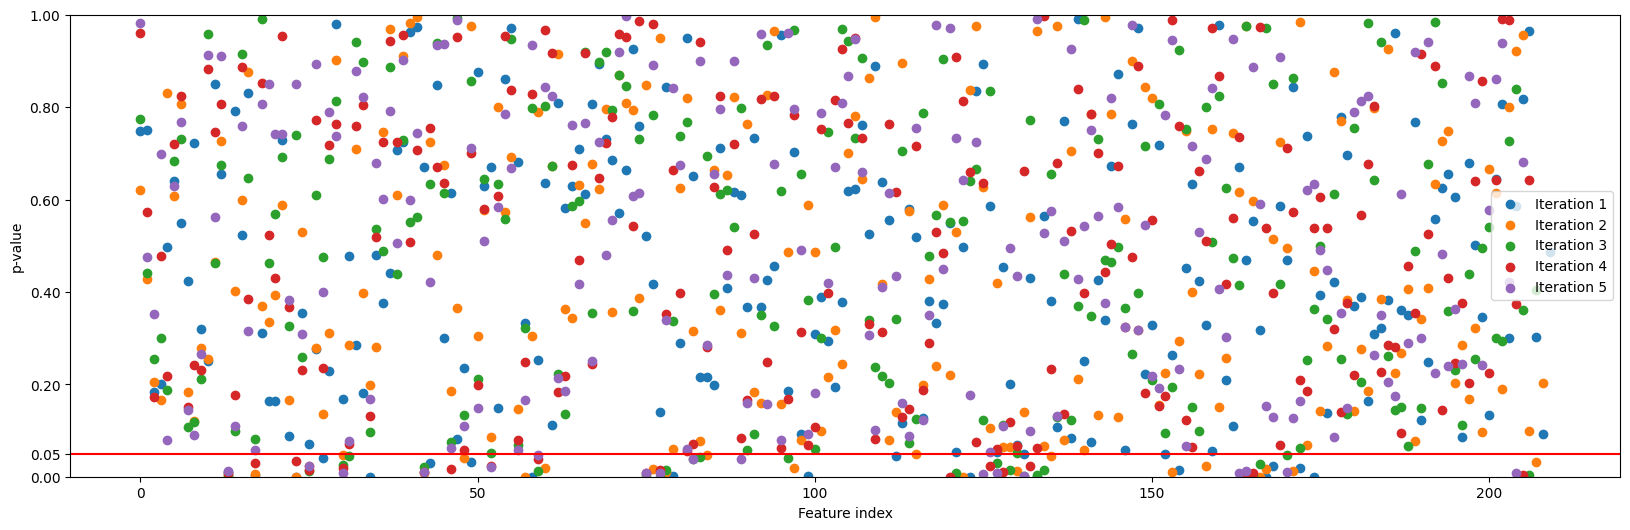

In [59]:
# @brief: Choose the best variables through forward variable selection.
# @param X: The data matrix of shape (n, p).
# @param y: The vector of responses of shape (n,).
# @param p_value_threshold: The threshold of p-value. (stop condition)
# @param show_flag: If True, print the selected features.
# @param plot_iter: The number of iterations to plot.
# @return: The list of selected features.

def forward_variable_selection(X, y, p_value_threshold=0.05, show_flag=False, plot_iter=5):
    _, p = X.shape
    remaining_features = list(range(0, p))
    chosed_features = []
    X_temp = X.copy()
    y_temp = y.copy().ravel()

    for i in range(p):
        plot_flag = False
        if (plot_iter != 0) and (i < plot_iter):
            plot_flag = True
            plot_label = f'Iteration {i + 1}'
        min_feature_idx, min_p_value, x_min, theta = choose_single_variable(X_temp, y_temp, plot_flag, plot_label)

        if min_p_value > p_value_threshold:
            break

        if show_flag:
            print(f'feature index : {min_feature_idx}, p_value : {min_p_value}')
        
        # add the selected feature to the list of selected features
        chosed_features.append([min_feature_idx, min_p_value])

        # remove the selected feature from the list of remaining features
        X_temp = np.delete(X_temp, min_feature_idx, axis=1)
        remaining_features.remove(min_feature_idx)

        # subtract the effect of the selected feature
        y_temp = y_temp - theta * x_min

    return chosed_features

chosed_features = []
plt.figure(figsize=(20, 6))
chosed_features = forward_variable_selection(X_train_scaled, y_train_scaled,
                           p_value_threshold=0.05, show_flag=True, plot_iter=5)

plt.xlabel('Feature index')
plt.ylabel('p-value')
plt.axhline(y=0.05, color='r', linestyle='-')
plt.ylim(0, 1)
plt.yticks(list(plt.yticks()[0]) + [0.05])
plt.show()

Why we need to subtracting the residuals ?

The residuals from the previous model (with fewer features) are subtracted from the original target variable. This subtraction effectively updates the target variable by removing the variance already explained by the features included in the model.

# Extensions

4\) Run ridge regression using scikit-learn on the training set. Run the code for 30 different values of the penalty parameter, which should be on a logarithmic scale between $10^{-1}$ and $10^6$. Display two subplots at the end:

(a) The first subplot should show the evolution of the coefficients for each different value of the penalty parameter.

(b) The second subplot should display the evolution of the R-squared coefficient at each of the 30 iterations.

Since we are going to perform similar tasks for Lasso and Elastic Net, it is mandatory to write this code as an independent function that can be parameterized for each specific case.

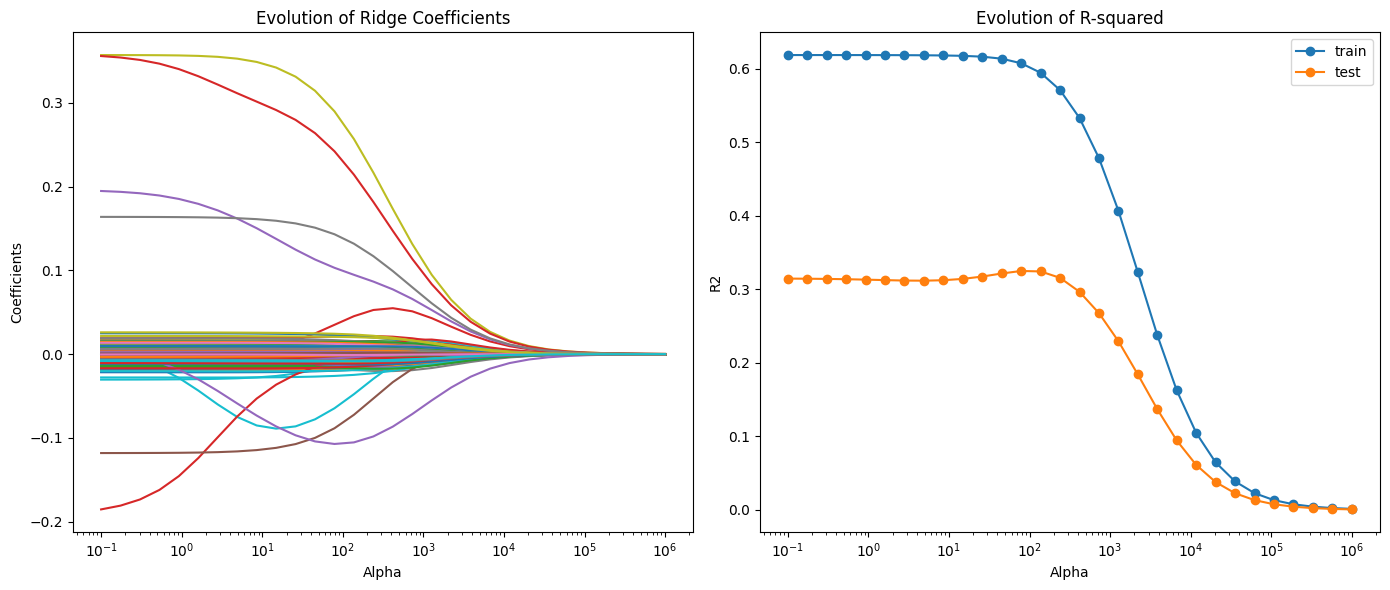

In [60]:
# @brief: run the different models with different regularization parameters and plot the coefficients and R-squared.
# @param X: The data matrix of shape (n, p).
# @param y: The vector of responses of shape (n,).
# @param alphas: The list of regularization parameters.
# @param reg_model: The name of the regularization model.
# @return: The coefficients of the different models.

def evaluation_plot(X, y, X_test, y_test, alphas, reg_model):
    coefficients = []
    r_squared = []
    r_squared_test = []

    for alpha in alphas:
        if reg_model == 'Ridge':
            reg = Ridge(alpha=alpha)
        elif reg_model == 'Lasso':
            reg = Lasso(alpha=alpha)
        elif reg_model == 'ElasticNet':
            np.random.seed(0)
            reg = ElasticNet(alpha=alpha, random_state=0, l1_ratio=0.4)
        reg.fit(X, y)
        coefficients.append(reg.coef_)
        r_squared.append(reg.score(X, y))
        r_squared_test.append(reg.score(X_test, y_test))

    coefficients = np.array(coefficients)

    plt.figure(figsize=(14, 6))
    # figure1: coefficients
    plt.subplot(1, 2, 1)
    for i in range(coefficients.shape[1]):
        plt.plot(alphas, coefficients[:, i])
    plt.xscale('log')
    plt.xlabel('Alpha')
    plt.ylabel('Coefficients')
    plt.title('Evolution of ' + reg_model + ' Coefficients')

    # figure2: R-squared
    plt.subplot(1, 2, 2)
    plt.plot(alphas, r_squared, marker='o', label='train')
    plt.plot(alphas, r_squared_test, marker='o', label='test')
    plt.xscale('log')
    plt.xlabel('Alpha')
    plt.ylabel('R2')
    plt.title('Evolution of R-squared')
    plt.tight_layout()
    plt.legend()
    plt.show()

    return coefficients


ridge_coeff = evaluation_plot(
    X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, np.logspace(-1, 6, 30), 'Ridge')

5\) Run the code for Lasso as explained in Point 4. Run the code for 30 different values of the penalty parameter, which should be on a logarithmic scale between $10^{-3}$ and $10^2$.

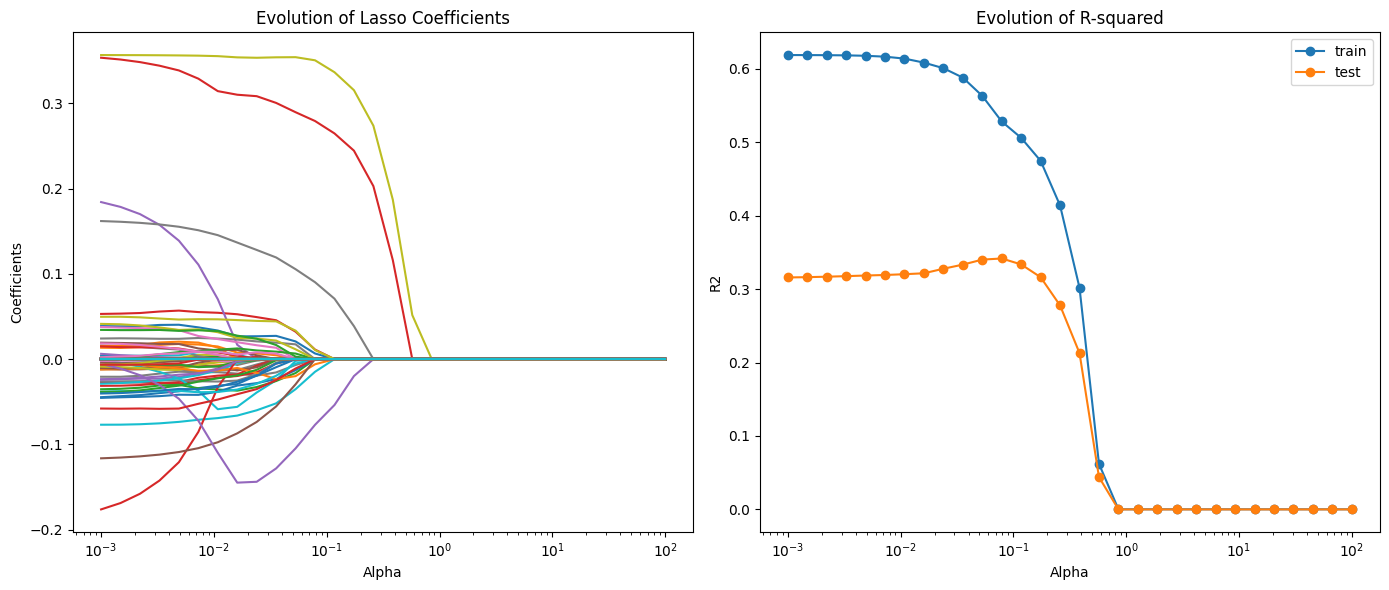

In [61]:
lasso_coeff = evaluation_plot(
    X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, np.logspace(-3, 2, 30), 'Lasso')

6\) Run the code for ElasticNet as explained in Point 4. Run the code for 30 different values of the penalty parameter, which should be on a logarithmic scale between $10^{-3}$ and $10^2$.

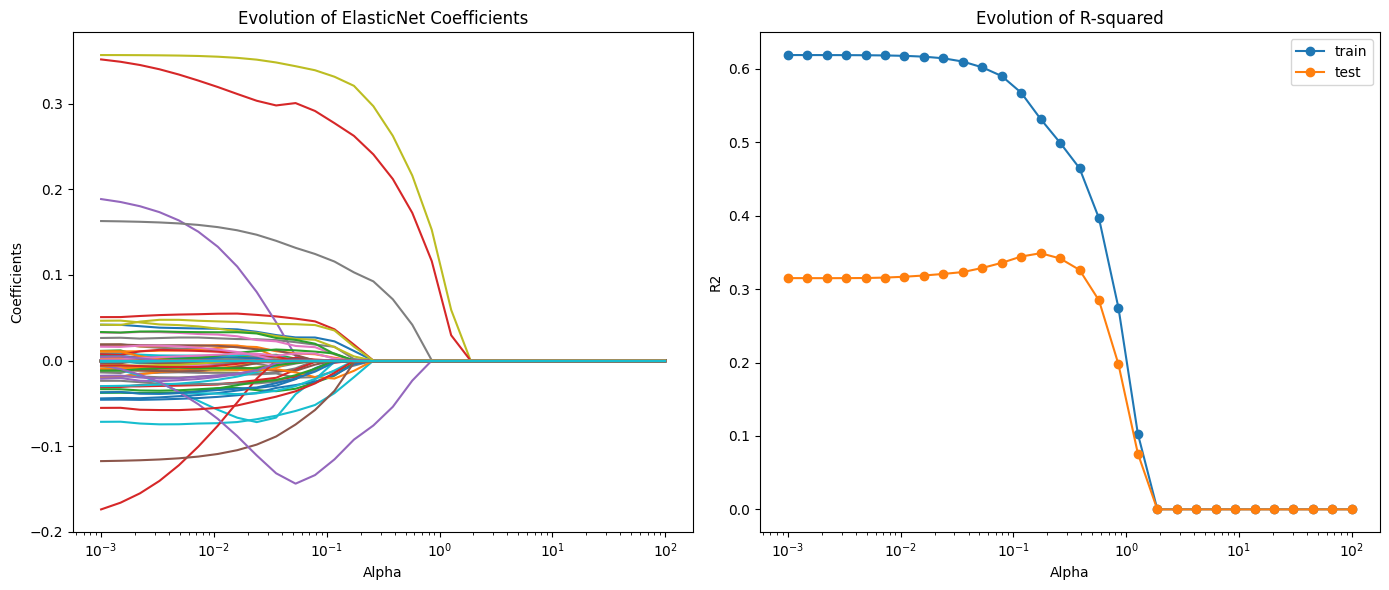

In [62]:
elastic_coeff = evaluation_plot(
    X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, np.logspace(-3, 2, 30), 'ElasticNet')

# PCA

7\) Compute the singular value decomposition of the covariance matrix. For consistency in the notation use $U, s, V = SVD(X^{T} X)$.


(a) Plot a heatmap of the covariance matrix.


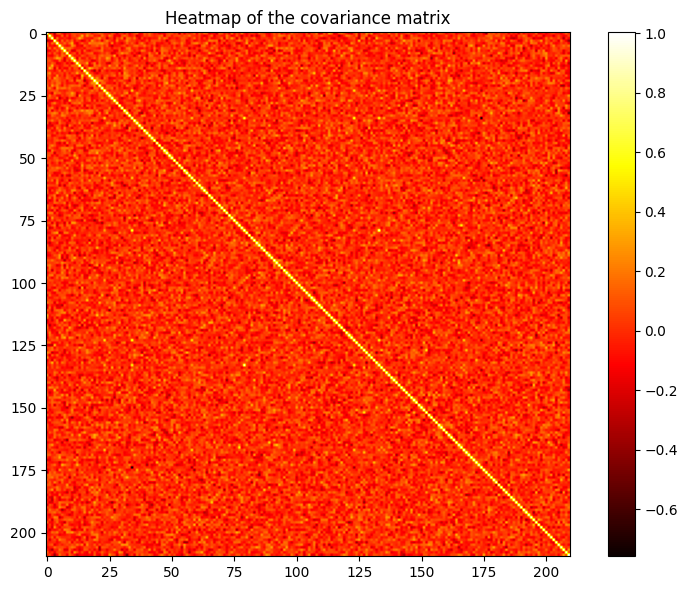

In [63]:
cov_mat = np.cov(X_train_scaled.T)

plt.figure(figsize=(8, 6))
plt.title('Heatmap of the covariance matrix')
plt.imshow(cov_mat, cmap='hot')
plt.colorbar()
plt.tight_layout()
plt.show()

(b) Compute the PCA for the data using the SVD.

In [64]:
# @brief: Use PCA to select the best k features.
# @param X: The data matrix of shape (n, p).
# @param k: The number of features to select.
# @return: The selected data matrix of shape (n, k).

def PCA(X, k):
    # Center X
    Xc = X - np.mean(X)
    cov_mat = np.cov(Xc.T)
    U, s, V = np.linalg.svd(cov_mat)
    eigen_vectors = U[:, :k]
    X_selected = np.dot(eigen_vectors.T, Xc.T).T
    return X_selected

(c) Plot the amount of variance explained by the ﬁrst $k$ components for $k = 2..p$. How many variables do we need to explain more than 90% of the variance?

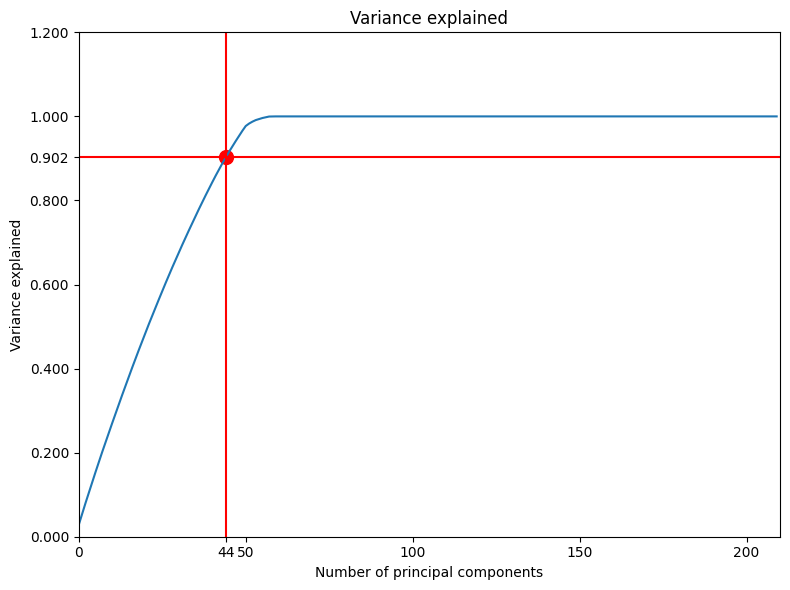

In [70]:
# Compute SVD
U_train, s_train, V_train = np.linalg.svd(X_train_scaled)

var_explained = np.cumsum(s_train**2) / np.sum(s_train**2)

plt.figure(figsize=(8, 6))
plt.plot(var_explained)
plt.title('Variance explained')
plt.xlabel('Number of principal components')
plt.ylabel('Variance explained')
idxs = np.where(var_explained >= 0.9)[0]
idx = idxs[0]
plt.axvline(idx, c='red')
plt.axhline(var_explained[idx], c='red')
plt.scatter(idx, var_explained[idx], c='red', s=100)
plt.yticks(list(plt.yticks()[0]) + [var_explained[idx]])
plt.xticks(list(plt.xticks()[0]) + [idx])
plt.xlim(0, len(var_explained))
plt.ylim(0, 1.2)
plt.tight_layout()
plt.show()

According to this figure, if we need to explain more than 90% of the variance, at least 44 components are needed.

(d) Plot the projected data with $k = 2$ using as color the value of y and interpret the plot.

(e) Plot the the two ﬁrst principal directions.

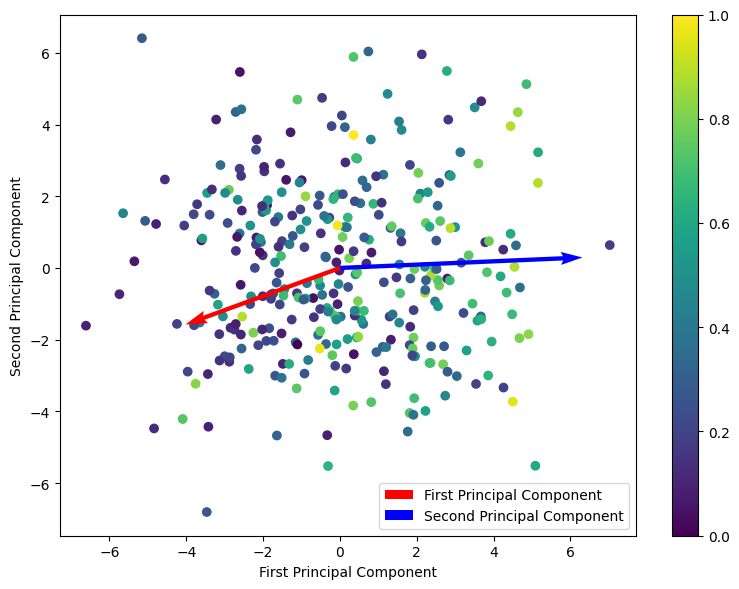

In [66]:
X_selected = PCA(X_train_scaled, 2)

plt.figure(figsize=(8, 6))
plt.scatter(X_selected[:, 0], X_selected[:, 1], c=y_train_scaled)
plt.quiver(0, 0, X_selected[0, 0], X_selected[0, 1], angles='xy',
           scale_units='xy', scale=0.5, color='red', label='First Principal Component')
plt.quiver(0, 0, X_selected[1, 0], X_selected[1, 1], angles='xy',
           scale_units='xy', scale=0.5, color='blue', label='Second Principal Component')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar()
plt.legend()
plt.tight_layout()
plt.show()

(f) Run OLS on the projected data (PCR) using $k$ components for $k < 50$. 

Select the $k$ that returns the best score of the OLS model and plot the evolution of the scores with $k$.

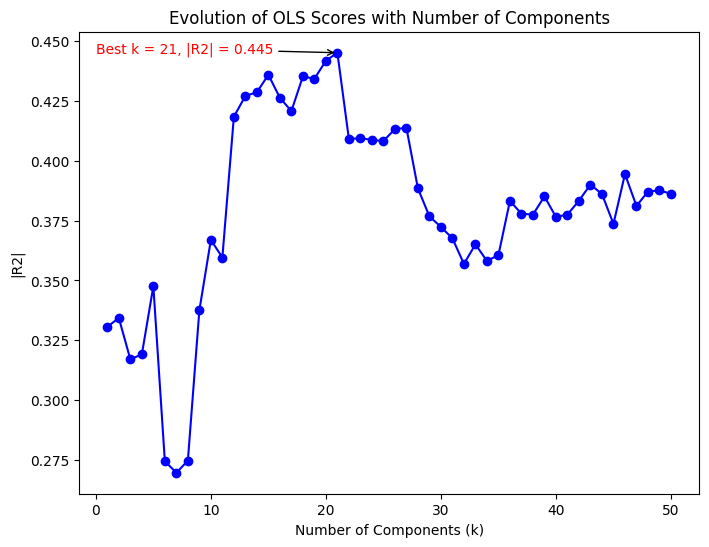

In [67]:
max_components = 50
ols_scores = []
pca_coeff = []

for k in range(1, max_components + 1):
    X_selected = PCA(X_train_scaled, k)
    reg_pca = LinearRegression(fit_intercept=True).fit(
        X_selected, y_train_scaled)
    pca_coeff.append(reg_pca.coef_)
    X_test_selected = PCA(X_test_scaled, k)
    ols_scores.append(np.abs(reg_pca.score(X_test_selected, y_test_scaled)))

# Find the best number of components
best_k = np.argmax(ols_scores) + 1

# Plot the evolution of scores with k
plt.figure(figsize=(8, 6))
plt.plot(range(1, max_components + 1), ols_scores,
         marker='o', linestyle='-', color='b')
plt.annotate(f'Best k = {best_k}, |R2| = {ols_scores[best_k - 1]:.3f}',
             xy=(best_k, ols_scores[best_k - 1]),
             # Adjust the position of the text
             xytext=(0, ols_scores[best_k - 1]),
             arrowprops=dict(facecolor='red', arrowstyle='->'), color='red')
plt.title('Evolution of OLS Scores with Number of Components')
plt.xlabel('Number of Components (k)')
plt.ylabel('|R2|')
plt.show()

# Comparison of the models

8\) Summarize the results of the models and elaborate in their main characteristics. Plot all the training and testing errors for all the models considered and elaborate on the results.

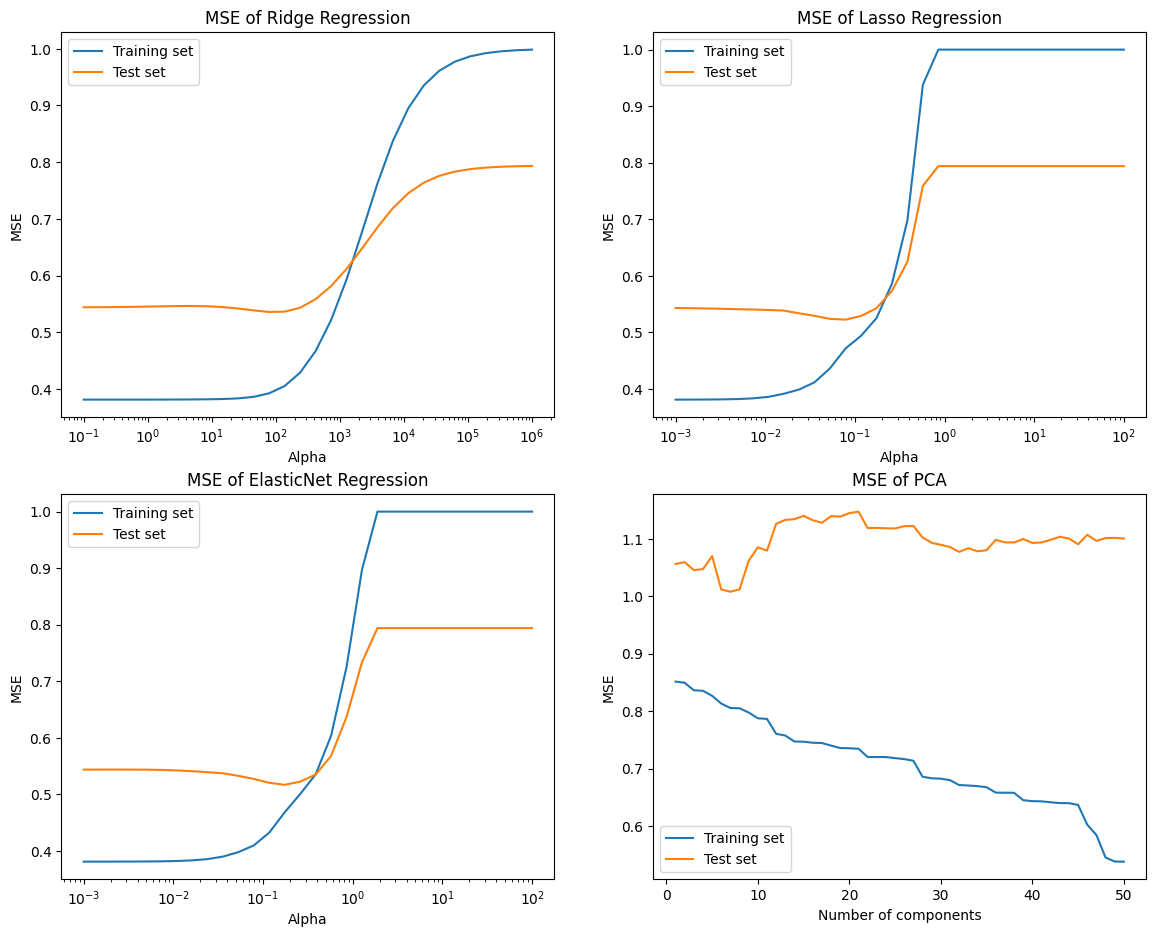

In [68]:
# MSE of ridge (training set and test set)
ridge_mse_train = []
ridge_mse_test = []
for i in range(30):
    y_train_pred = ridge_coeff[i, :].dot(X_train_scaled.T)
    ridge_mse_train.append(compute_MSE(y_train_scaled, y_train_pred))
    y_test_pred = ridge_coeff[i, :].dot(X_test_scaled.T)
    ridge_mse_test.append(compute_MSE(y_test_scaled, y_test_pred))
plt.figure(figsize=(14, 11))
plt.subplot(2, 2, 1)
plt.plot(np.logspace(-1, 6, 30), ridge_mse_train, label='Training set')
plt.plot(np.logspace(-1, 6, 30), ridge_mse_test, label='Test set')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('MSE of Ridge Regression')
plt.legend()

# MSE of lasso (training set and test set)
lasso_mse_train = []
lasso_mse_test = []
for i in range(30):
    y_train_pred = lasso_coeff[i, :].dot(X_train_scaled.T)
    lasso_mse_train.append(compute_MSE(y_train_scaled, y_train_pred))
    y_test_pred = lasso_coeff[i, :].dot(X_test_scaled.T)
    lasso_mse_test.append(compute_MSE(y_test_scaled, y_test_pred))
plt.subplot(2, 2, 2)
plt.plot(np.logspace(-3, 2, 30), lasso_mse_train, label='Training set')
plt.plot(np.logspace(-3, 2, 30), lasso_mse_test, label='Test set')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('MSE of Lasso Regression')
plt.legend()

# MSE of elastic net (training set and test set)
elastic_mse_train = []
elastic_mse_test = []
for i in range(30):
    y_train_pred = elastic_coeff[i, :].dot(X_train_scaled.T)
    elastic_mse_train.append(compute_MSE(y_train_scaled, y_train_pred))
    y_test_pred = elastic_coeff[i, :].dot(X_test_scaled.T)
    elastic_mse_test.append(compute_MSE(y_test_scaled, y_test_pred))
plt.subplot(2, 2, 3)
plt.plot(np.logspace(-3, 2, 30), elastic_mse_train, label='Training set')
plt.plot(np.logspace(-3, 2, 30), elastic_mse_test, label='Test set')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('MSE of ElasticNet Regression')
plt.legend()

# MSE of PCA (training set and test set)
pca_mse_train = []
pca_mse_test = []
for i in range(50):
    X_train_selected = PCA(X_train_scaled, i + 1)
    y_train_pred = X_train_selected.dot(pca_coeff[i])
    pca_mse_train.append(compute_MSE(y_train_scaled, y_train_pred))
    X_test_selected = PCA(X_test_scaled, i + 1)
    y_test_pred = X_test_selected.dot(pca_coeff[i])
    pca_mse_test.append(compute_MSE(y_test_scaled, y_test_pred))
plt.subplot(2, 2, 4)
plt.plot(range(1, 51), pca_mse_train, label='Training set')
plt.plot(range(1, 51), pca_mse_test, label='Test set')
plt.xlabel('Number of components')
plt.ylabel('MSE')
plt.title('MSE of PCA')
plt.legend()
plt.show()

For `Ridge Regression`, as the regularization parameter $\alpha$ increases, the MSE increases for both the training data and test data. When $\alpha$ gets small, the model performs better on the training data than on the test data, which indicates that the model may be overfitting. As alpha increases, the training error increases and the test error first decreases and then increases, indicating the effectiveness of regularization in controlling overfitting.

`Lasso Regression` aims to produce a sparser model by adding an L1 regular term to the loss function, which can be achieved by reducing certain coefficients to zero. In `Lasso Regression`, for smaller values of $\alpha$, the model has a much lower MSE on the training set than on the test set, again pointing to overfitting. However, as $\alpha$ increases, the MSE on the test set rises faster than on the training set. This indicates that the model's fit to the training data decreases as $\alpha$ increases, leading to a more significant drop in performance on unseen data.

`ElasticNet Regression` is a combination of `Ridge Regression` (L2 regularization) and `Lasso Regression` (L1 regularization), which tries to combine the advantages of both. When the $\alpha$ is small, the MSE is lower for both the training and test sets, indicating that `ElasticNet Regression` fits the data well. As $\alpha$ increases, `ElasticNet Regression`'s MSE rises on both the training and test sets, but the rate of increase on the test set does not seem to be as dramatic as in `Lasso Regression`. This may be due to the effect of L2 regularization, which prevents the weights from becoming too small and thus somewhat suppresses the complete elimination of certain features in the `Lasso Regression`. Compared to `Lasso Regression`, `ElasticNet Regression` penalizes features with a combination of L1 and L2 regularization, which may cause it to be more gentle in excluding features rather than reducing many of the coefficients to zero as `Lasso Regression` does. This helps to retain more information, especially when there are multiple related features, and `ElasticNet Regression` may choose to retain features within those groups rather than just one of them as `Lasso Regression` may do. Compared to `Ridge Regression`, `ElasticNet Regression` introduces L1 regularization, which enables feature selection in the model, which is not possible in `Ridge Regression`, which tends to give some weight to all features instead of setting some coefficients to zero.

In the graphs for `PCA`, the MSE for the training set continues to decrease as the number of components increases, due to the model's ability to capture more data variability and thus better fit the training data. However, the MSE for the test set is increasing, which may indicate that as the model complexity increases, the model begins to overfit the training data, leading to a decrease in generalization ability on test data. In contrast to `Ridge Regression`, `Lasso Regression` and `ElasticNet Regression`, `PCA` acts as a dimensionality reduction technique which aims to reduce the number of features in the dataset and hence the complexity of the model. However, instead of controlling the complexity of the model directly, `PCA` achieves this by reducing the dimensionality of the data. This may work well on the training set, but if the test set contains different variability than the training set, the model may not generalize well.